# This notebook is divided into three main sections:
### 1. Data Importing and Preprocessing
### 2. Dimensionality Reduction
### 3. Unsupervised Classification

## 1. Data Importing and Preprocessing

Here, I import data from my local storage. The images pixel range is 16 bits and the format is TIFF and hence, it is imported through the tifffile library. 
Before importing the images, we check if the number of non zero pixels are below a certain threshold. It indicates it is a low resolution/ bad band and we don't consider them in our analysis

In [1]:
# Importing data from a local folder

import tifffile as tiff
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

X_data = []
files = glob.glob ("C://Users//Aditya Mohan//Documents//Pixxel//EO1H1430452010208110Kt_1GST//EO1H1430452010208110Kt//*.TIF")
for myFile in files:

    image = cv2.imread(myFile,0)
    # Detecting bad bands if the ratio of non black pixels are less than 8% of the enitre image and neglecting them
    rows ,columns = image.shape
    if (cv2.countNonZero(image) < (0.08 * rows * columns )):
        continue
    image = tiff.imread(myFile)
    X_data.append(image)


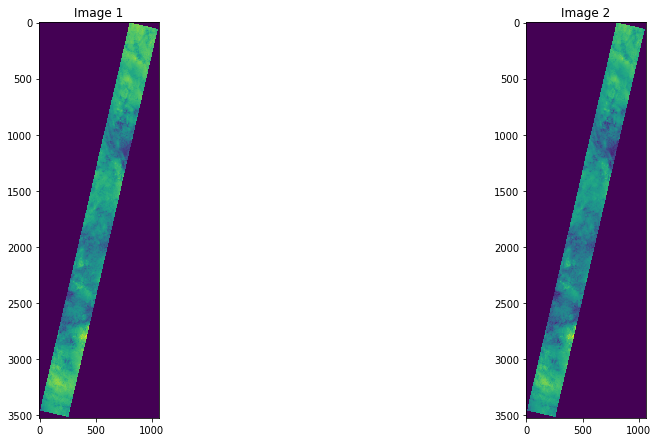

In [6]:
# Displaying random images from the dataset
fig = plt.figure(figsize = (16,16))
im1 = X_data[2]
im2 = X_data[17]


a = fig.add_subplot(2,2,1)
a.set_title('Image 1')
plt.imshow(im1)



b = fig.add_subplot(2,2,2)
b.set_title('Image 2')
plt.imshow(im2)

plt.show()

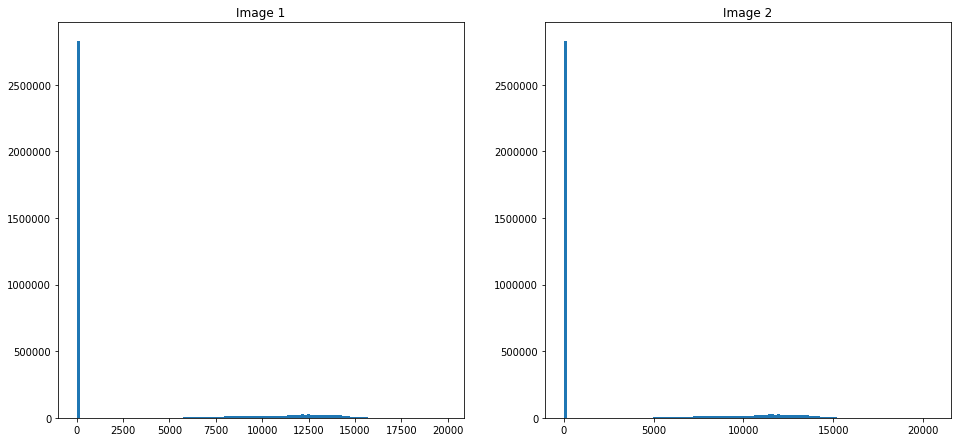

In [7]:
# Displaying Histograms of the above images from the dataset

from pylab import *

fig = plt.figure(figsize = (16,16))

a = fig.add_subplot(2,2,1)
a.set_title('Image 1')
hist(im1.flatten(),128)



b = fig.add_subplot(2,2,2)
b.set_title('Image 2')
hist(im2.flatten(),128)

plt.show()

In [8]:
# Histogram Equalizing and Contrast Stretching of images

from skimage import exposure

X_data_mod = []

for image in X_data:
 
    # Histo
    image_eq = exposure.equalize_hist(image)
    
    p2 = np.percentile(image_eq, 2)
    p98 = np.percentile(image_eq, 98)
    image_ct = exposure.rescale_intensity(image_eq, in_range=(p2, p98))
    
    
    X_data_mod.append(image_ct)


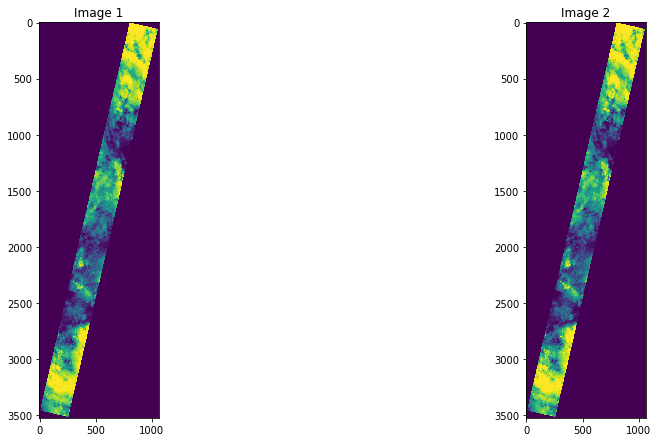

In [9]:
# Displaying random images after Histogram Equalizing and Contrast Stretching from the dataset
fig = plt.figure(figsize = (16,16))
im1 = X_data_mod[4]
im2 = X_data_mod[17]


a = fig.add_subplot(2,2,1)
a.set_title('Image 1')
plt.imshow(im1)



b = fig.add_subplot(2,2,2)
b.set_title('Image 2')
plt.imshow(im2)

plt.show()

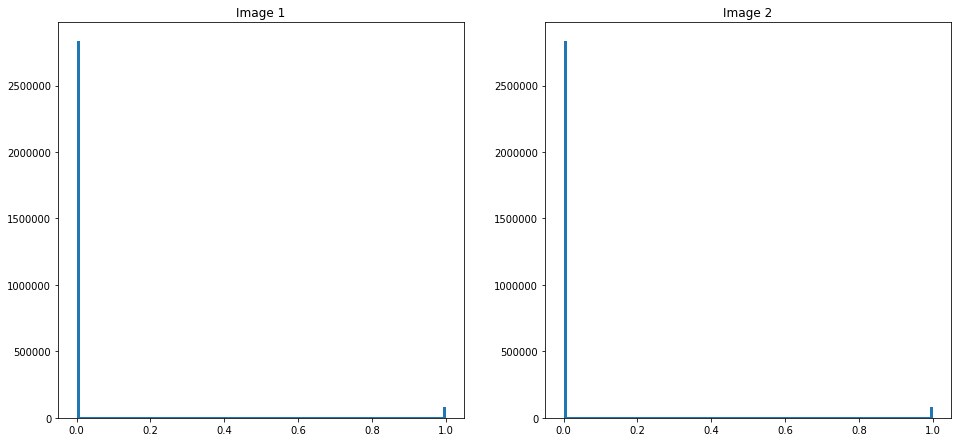

In [10]:
# Displaying Histograms of the above images from the dataset after preprocessing

from pylab import *

fig = plt.figure(figsize = (16,16))

a = fig.add_subplot(2,2,1)
a.set_title('Image 1')
hist(im1.flatten(),128)



b = fig.add_subplot(2,2,2)
b.set_title('Image 2')
hist(im2.flatten(),128)

plt.show()

In [11]:
# Converting list into an array
X_train_array = np.array(X_data_mod)
print(X_train_array.shape)

(161, 3521, 1061)


In [12]:
#Flattening the array

dims, orig_rows, orig_cols = X_train_array.shape
X_flat = X_train_array.reshape((dims, orig_rows*orig_cols))
print(X_flat.shape)

(161, 3735781)


In [13]:
# Transposing to select principal components of the band dimension

X_flat_transposed = np.transpose(X_flat)
print(X_flat_transposed.shape)

(3735781, 161)


In [14]:
X_flat.shape

(161, 3735781)

## 2. Dimensionality Reduction

We use Principal Component analysis to reduce the dimension of the remaining 176 bands into just 4 principle components. This is done using the Incremental PCA function imported from the Scikit-learn library. Incremental PCA is chosen because of the large number of features in the input data and would work well running it in small batches.


In [15]:
#Using the IncrementalPCA method from the scikit-learn library

from sklearn.decomposition import IncrementalPCA

IPCA = IncrementalPCA(n_components=4, batch_size = 5)
X_IPCA = IPCA.fit_transform(X_flat_transposed)

print(X_IPCA.shape)

C:\Users\Anaconda3\lib\site-packages\sklearn\decomposition\_incremental_pca.py:301: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)


(3735781, 4)


In [16]:
#Array is transposed to be consistent with the original format

X_IPCA = np.transpose(X_IPCA)
X_IPCA.shape

(4, 3735781)



 After obtaining the principal components, the first (most important) principal component is obtained and used for image segmentation



3521 1061


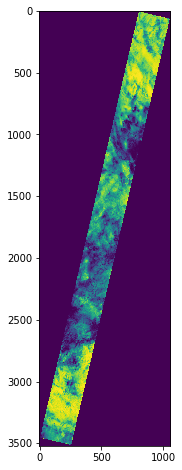

In [18]:
#Displaying the first Principle Component

PC_1 = X_IPCA[0].reshape(orig_rows,orig_cols)
print(orig_rows,orig_cols)
figure = plt.figure(figsize = (8,8))
plt.imshow(PC_1)

## 3. Unsupervised Classification

Here, we use the elbow method to find the optimal value of the number of clusters used for image segmentation through the unsupervised K-means algorithm. Upon obtaining the value, we use it to segment 4 of the most import principal components.

In [19]:
from PIL import Image

In [20]:
# Function to crop image

def crop(image):
    y_nonzero, x_nonzero = np.nonzero(image)
    return image[0:rows, 400:650]

In [21]:
# Function to rotate image and crop to obtain a better display and extract important features of the image

def correct_image(image, angle_of_rotation):
    im_pil = Image.fromarray(image)
    rotated     = im_pil.rotate(angle_of_rotation)
    segmented_image = np.asarray(rotated)
    cropped_image = crop(segmented_image)
    rows,cols = cropped_image.shape
    return cropped_image, rows, cols

In [22]:

corrected_image,rows,cols = correct_image(PC_1,13)
vectorized = corrected_image.reshape((rows*cols), 1)
vectorized.shape

(880250, 1)

In [23]:

from sklearn.cluster import KMeans

score = []

for cluster in range(2,8):
    kmeans = KMeans(n_clusters = cluster, init="k-means++", random_state=10)
    kmeans.fit(vectorized)
    score.append(kmeans.inertia_)

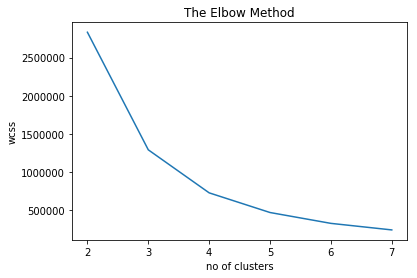

In [24]:
# Plotting the score

plt.plot(range(2,8), score)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the inertia start decreasing in a linear fashion. 
Thus for the given data, we conclude that the optimal number of clusters for the data is 4.

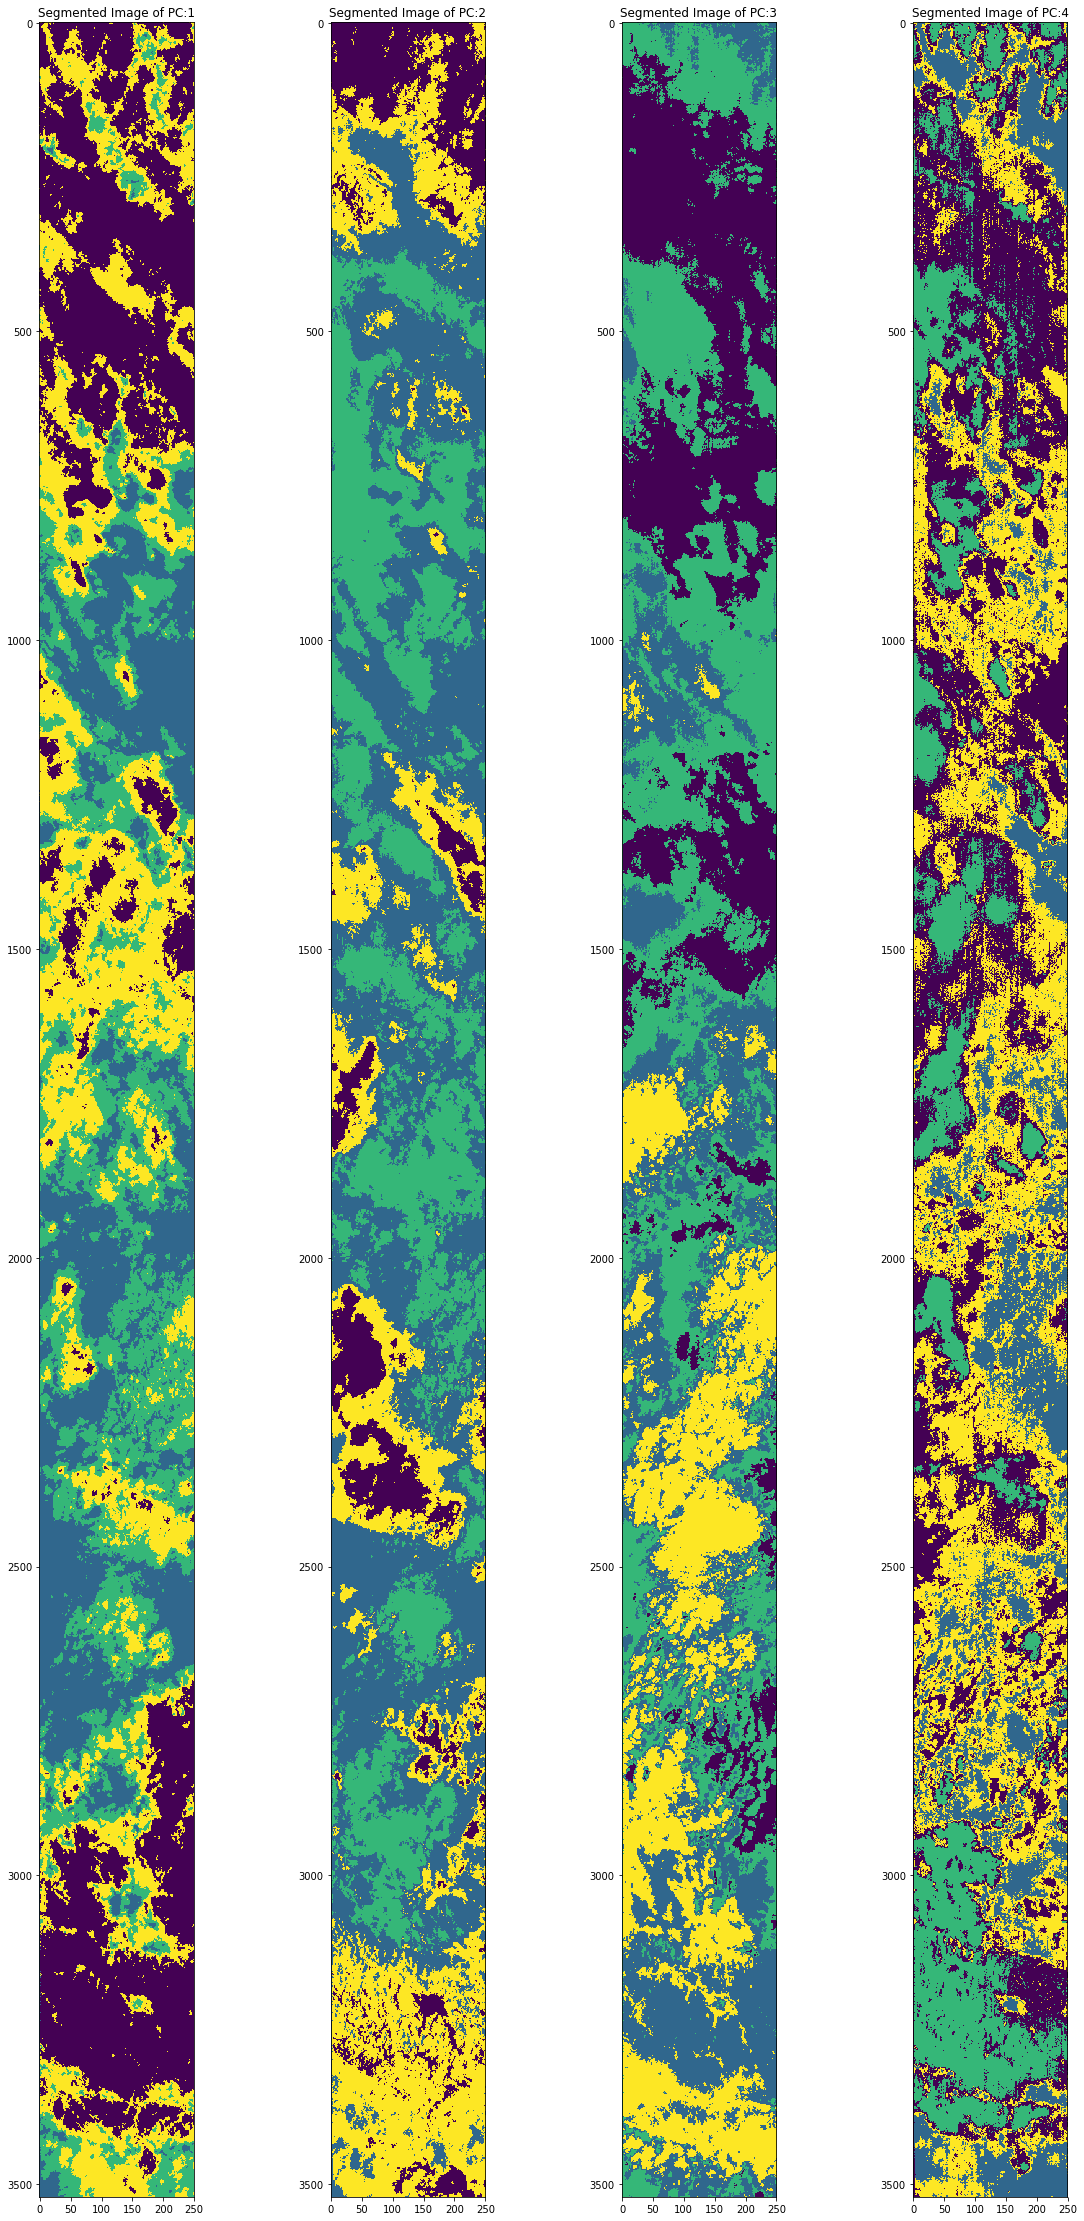

In [25]:
#Run KMeans to Segment the first four principle components

fig = plt.figure(figsize=(20, 40))
segmented_images = []
kmeans = KMeans(random_state=0, init='random', n_clusters=4)
for PC_No in range(0,4):
    
    corrected_image, r,c = correct_image(X_IPCA[PC_No].reshape(orig_rows,orig_cols) , 13)
    vectorized = corrected_image.reshape((r*c), 1)
    labels = kmeans.fit_predict(vectorized)
    
    segmented_image = labels.reshape(r,c)
    segmented_images.append(segmented_image)
    a = fig.add_subplot(1,4,PC_No+1)  
    i = PC_No+1
    a.set_title("Segmented Image of PC:{}".format(i))
    
    plt.imshow(segmented_image)
    
    
    
plt.show()    

Here, we have obtained the first four principle components of the dataset. From here on, we'll use these four already segmented bands and merge them in order to create a false color image, which would be the final segmented image that we require.

First, we'll measure the clustering performance using the davies_bouldin evaluation metric. The image used is the first principle component for this purpose

In [26]:
corrected_image, r,c = correct_image(X_IPCA[0].reshape(orig_rows,orig_cols) , 13)
vectorized = corrected_image.reshape((r*c), 1) 
kmeans = KMeans(random_state=0, init='random', n_clusters=4)
labels = kmeans.fit_predict(vectorized)

In [27]:
#We use the davies_bouldin_score as a clustering performance metric

from sklearn.metrics import davies_bouldin_score
score = davies_bouldin_score(vectorized, labels)
print(score)

0.5070338663651182


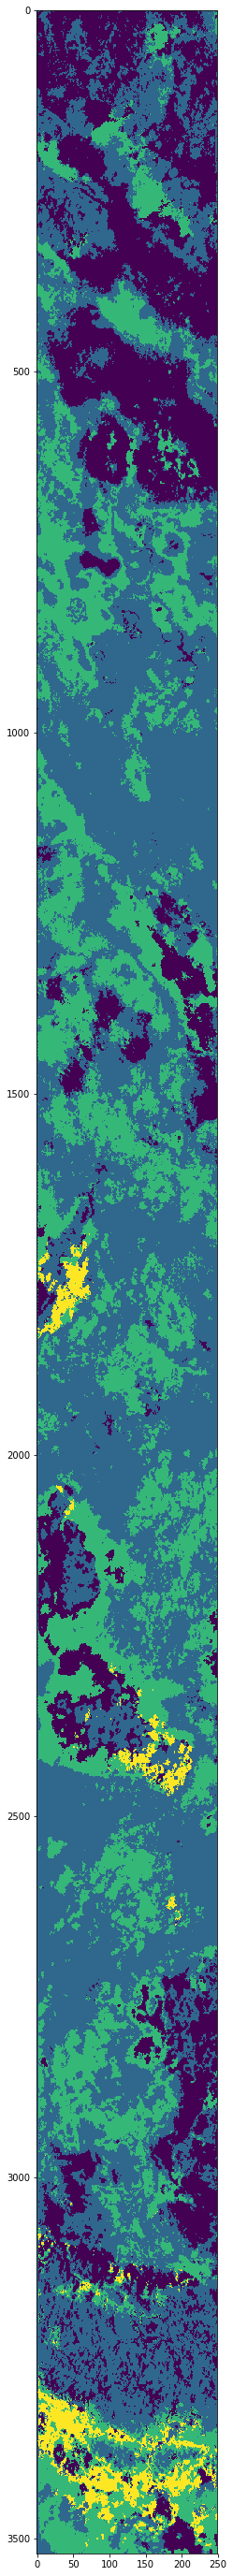

In [28]:
# Convert these into single channel 8 bit pixels and finally merge them into the RGBA format - which represents the false colour image

fig = plt.figure(figsize=(25, 50))


im_pil0 = Image.fromarray(segmented_images[0])
im0 = im_pil0.convert('L')


im_pil1 = Image.fromarray(segmented_images[1])
im1 = im_pil1.convert('L')


im_pil2 = Image.fromarray(segmented_images[2])
im2 = im_pil2.convert('L')


im_pil3 = Image.fromarray(segmented_images[3])
im3 = im_pil3.convert('L')

final_segmented_image_pil = Image.merge( 'RGBA' , (im0, im1, im2, im3) ).convert("I")
plt.imshow(final_segmented_image_pil)

This is the final segmented false colour image